# Basic Tabular Data: DDC vs Random vs Stratified

This notebook demonstrates the basic usage of `dd-coresets` on simple tabular data. We'll compare **Density-Diversity Coresets (DDC)** with **Random** and **Stratified** sampling.

## What You'll Learn

- How to install and use `dd-coresets`
- Basic API: `fit_ddc_coreset`, `fit_random_coreset`, `fit_stratified_coreset`
- Understanding distributional metrics (Mean, Covariance, Wasserstein-1)
- When DDC is better than Random (clustered data)

## The Dataset

We'll use a simple **Gaussian mixture** with 3 clusters and 8 features. This structure is common in real-world data and demonstrates DDC's advantage.

## 1. Setup

In [1]:
# Install dd-coresets (uncomment if needed)
# !pip install dd-coresets

# For Kaggle/Colab, you may need:
# !pip install dd-coresets --quiet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Try importing UMAP, fallback to PCA if not available
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("UMAP not available, using PCA for visualization")

from dd_coresets import (
    fit_ddc_coreset,
    fit_random_coreset,
    fit_stratified_coreset,
)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

UMAP not available, using PCA for visualization


### Why Gaussian Mixtures?

Gaussian mixtures with well-separated clusters are ideal for demonstrating DDC because:

- **Clustered structure**: DDC excels when data has clear modes (clusters)
- **Spatial coverage**: DDC guarantees all clusters are represented, even small ones
- **Distribution preservation**: The weighted coreset preserves both the location (mean) and shape (covariance) of each cluster

**Conceptual note**: In high dimensions, k-NN density estimation works well when clusters are separated. Points in dense regions (clusters) have many close neighbors, leading to high density estimates. DDC uses these estimates to prioritize important regions while ensuring diversity (spatial coverage).

### What Happens During DDC Fitting?

The `fit_ddc_coreset` function performs three main steps:

1. **Density Estimation**: Estimates local density for each point using k-nearest neighbors. Points in dense regions (clusters) get high density scores.

2. **Greedy Selection**: Iteratively selects points that balance high density (important regions) with diversity (spatial coverage). The `alpha` parameter (default 0.3) controls this trade-off.

3. **Weight Assignment**: Assigns weights to selected points using soft assignments. A point with weight 0.1 "stands for" 10% of the original data in that region.

**Why weights matter**: Unlike simple sampling where each point represents 1/n of the data, weights allow a small coreset to accurately represent the full distribution. This is similar to how a histogram uses bin counts, but DDC uses actual data points with weights.

See [Algorithm Overview](../concepts/algorithm.md) for more details.

### Why Gaussian Mixtures?

Gaussian mixtures with well-separated clusters are ideal for demonstrating DDC because:

- **Clustered structure**: DDC excels when data has clear modes (clusters)
- **Spatial coverage**: DDC guarantees all clusters are represented, even small ones
- **Distribution preservation**: The weighted coreset preserves both the location (mean) and shape (covariance) of each cluster

**Conceptual note**: In high dimensions, k-NN density estimation works well when clusters are separated. Points in dense regions (clusters) have many close neighbors, leading to high density estimates. DDC uses these estimates to prioritize important regions while ensuring diversity (spatial coverage).

### What Happens During DDC Fitting?

The `fit_ddc_coreset` function performs three main steps:

1. **Density Estimation**: Estimates local density for each point using k-nearest neighbors. Points in dense regions (clusters) get high density scores.

2. **Greedy Selection**: Iteratively selects points that balance high density (important regions) with diversity (spatial coverage). The `alpha` parameter (default 0.3) controls this trade-off.

3. **Weight Assignment**: Assigns weights to selected points using soft assignments. A point with weight 0.1 "stands for" 10% of the original data in that region.

**Why weights matter**: Unlike simple sampling where each point represents 1/n of the data, weights allow a small coreset to accurately represent the full distribution. This is similar to how a histogram uses bin counts, but DDC uses actual data points with weights.

See [Algorithm Overview](../concepts/algorithm.md) for more details.

### What Happens During DDC Fitting?

The `fit_ddc_coreset` function performs three main steps:

1. **Density Estimation**: Estimates local density for each point using k-nearest neighbors. Points in dense regions (clusters) get high density scores.

2. **Greedy Selection**: Iteratively selects points that balance high density (important regions) with diversity (spatial coverage). The `alpha` parameter (default 0.3) controls this trade-off.

3. **Weight Assignment**: Assigns weights to selected points using soft assignments. A point with weight 0.1 "stands for" 10% of the original data in that region.

**Why weights matter**: Unlike simple sampling where each point represents 1/n of the data, weights allow a small coreset to accurately represent the full distribution. This is similar to how a histogram uses bin counts, but DDC uses actual data points with weights.

See [Algorithm Overview](../concepts/algorithm.md) for more details.

## 2. Generate Dataset

We'll create a Gaussian mixture with **3 clusters** and **8 features**. The clusters are well-separated, which is where DDC typically excels.

In [3]:
# Generate Gaussian mixture
n_samples = 10000
n_features = 8
n_clusters = 3

X, cluster_labels = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    cluster_std=1.5,
    center_box=(-10, 10),
    random_state=RANDOM_STATE,
)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"Dataset shape: {X.shape}")
print(f"Number of clusters: {n_clusters}")
print(f"Cluster sizes: {np.bincount(cluster_labels)}")

Dataset shape: (10000, 8)
Number of clusters: 3
Cluster sizes: [3334 3333 3333]


### Why Gaussian Mixtures?

Gaussian mixtures with well-separated clusters are ideal for demonstrating DDC because:

- **Clustered structure**: DDC excels when data has clear modes (clusters)
- **Spatial coverage**: DDC guarantees all clusters are represented, even small ones
- **Distribution preservation**: The weighted coreset preserves both the location (mean) and shape (covariance) of each cluster

**Conceptual note**: In high dimensions, k-NN density estimation works well when clusters are separated. Points in dense regions (clusters) have many close neighbors, leading to high density estimates. DDC uses these estimates to prioritize important regions while ensuring diversity (spatial coverage).

### Why Gaussian Mixtures?

Gaussian mixtures with well-separated clusters are ideal for demonstrating DDC because:

- **Clustered structure**: DDC excels when data has clear modes (clusters)
- **Spatial coverage**: DDC guarantees all clusters are represented, even small ones
- **Distribution preservation**: The weighted coreset preserves both the location (mean) and shape (covariance) of each cluster

**Conceptual note**: In high dimensions, k-NN density estimation works well when clusters are separated. Points in dense regions (clusters) have many close neighbors, leading to high density estimates. DDC uses these estimates to prioritize important regions while ensuring diversity (spatial coverage).

## 3. Visualize Original Data

Let's visualize the data in 2D using UMAP (or PCA if UMAP is not available).

In [4]:
# Project to 2D for visualization
if HAS_UMAP:
    reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
    X_2d = reducer.fit_transform(X)
else:
    reducer = PCA(n_components=2, random_state=RANDOM_STATE)
    X_2d = reducer.fit_transform(X)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels,
                      cmap='viridis', alpha=0.5, s=10)
plt.colorbar(scatter, label='Cluster')
plt.title('Original Data (2D Projection)', fontsize=14, fontweight='bold')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()

# Save figure
import os
os.makedirs('images/tutorials/basic_tabular', exist_ok=True)
plt.savefig('images/tutorials/basic_tabular/original_data_2d.png', dpi=150, bbox_inches='tight')
plt.show()

![2D projection of original Gaussian mixture data with 3 clusters](../_images/original_data_2d.png)

*Original dataset projected to 2D using UMAP (or PCA). Colors represent different clusters.*


## 4. Fit Coresets

Now we'll create coresets using three methods:

1. **DDC**: Density-Diversity Coreset (unsupervised)
2. **Random**: Uniform random sampling
3. **Stratified**: Stratified sampling by cluster

We'll use `k=200` representatives (2% of the data).

In [5]:
k = 200  # Number of representatives

print("Fitting coresets...")
print("=" * 60)

# DDC (using default simplest preset)
S_ddc, w_ddc, info_ddc = fit_ddc_coreset(
    X, k=k, mode='euclidean', random_state=RANDOM_STATE
)
print(f"✓ DDC: {len(S_ddc)} representatives")
print(f"  Pipeline: {info_ddc['pipeline']}")

# Random
S_random, w_random, info_random = fit_random_coreset(
    X, k=k, random_state=RANDOM_STATE + 1
)
print(f"✓ Random: {len(S_random)} representatives")

# Stratified (by cluster)
S_strat, w_strat, info_strat = fit_stratified_coreset(
    X, strata=cluster_labels, k=k, random_state=RANDOM_STATE + 2
)
print(f"✓ Stratified: {len(S_strat)} representatives")
print("=" * 60)

Fitting coresets...


✓ DDC: 200 representatives
  Pipeline: {'mode': 'euclidean', 'preset': 'balanced', 'adaptive': False, 'pca_used': False, 'd_original': 8, 'd_effective': 8, 'fallbacks': []}
✓ Random: 200 representatives
✓ Stratified: 200 representatives


### What Happens During DDC Fitting?

The `fit_ddc_coreset` function performs three main steps:

1. **Density Estimation**: Estimates local density for each point using k-nearest neighbors. Points in dense regions (clusters) get high density scores.

2. **Greedy Selection**: Iteratively selects points that balance high density (important regions) with diversity (spatial coverage). The `alpha` parameter (default 0.3) controls this trade-off.

3. **Weight Assignment**: Assigns weights to selected points using soft assignments. A point with weight 0.1 "stands for" 10% of the original data in that region.

**Why weights matter**: Unlike simple sampling where each point represents 1/n of the data, weights allow a small coreset to accurately represent the full distribution. This is similar to how a histogram uses bin counts, but DDC uses actual data points with weights.

See [Algorithm Overview](../concepts/algorithm.md) for more details.

### What Happens During DDC Fitting?

The `fit_ddc_coreset` function performs three main steps:

1. **Density Estimation**: Estimates local density for each point using k-nearest neighbors. Points in dense regions (clusters) get high density scores.

2. **Greedy Selection**: Iteratively selects points that balance high density (important regions) with diversity (spatial coverage). The `alpha` parameter (default 0.3) controls this trade-off.

3. **Weight Assignment**: Assigns weights to selected points using soft assignments. A point with weight 0.1 "stands for" 10% of the original data in that region.

**Why weights matter**: Unlike simple sampling where each point represents 1/n of the data, weights allow a small coreset to accurately represent the full distribution. This is similar to how a histogram uses bin counts, but DDC uses actual data points with weights.

See [Algorithm Overview](../concepts/algorithm.md) for more details.

### What Happens During DDC Fitting?

The `fit_ddc_coreset` function performs three main steps:

1. **Density Estimation**: Estimates local density for each point using k-nearest neighbors. Points in dense regions (clusters) get high density scores.

2. **Greedy Selection**: Iteratively selects points that balance high density (important regions) with diversity (spatial coverage). The `alpha` parameter (default 0.3) controls this trade-off.

3. **Weight Assignment**: Assigns weights to selected points using soft assignments. A point with weight 0.1 "stands for" 10% of the original data in that region.

**Why weights matter**: Unlike simple sampling where each point represents 1/n of the data, weights allow a small coreset to accurately represent the full distribution. This is similar to how a histogram uses bin counts, but DDC uses actual data points with weights.

See [Algorithm Overview](../concepts/algorithm.md) for more details.

## 5. Compute Metrics

We'll compute distributional metrics to compare how well each coreset preserves the original distribution.

In [6]:
def wasserstein_1d_approx(x1, x2, w2=None, n_samples=5000):
    """Approximate Wasserstein-1 distance for 1D distributions."""
    if w2 is not None:
        probs = w2 / w2.sum()
        idx = np.random.choice(len(x2), size=n_samples, p=probs, replace=True)
        x2_sampled = x2[idx]
    else:
        x2_sampled = x2
    
    x1_sorted = np.sort(x1)
    x2_sorted = np.sort(x2_sampled)
    n = min(len(x1_sorted), len(x2_sorted))
    quantiles = np.linspace(0, 1, n)
    q1 = np.quantile(x1_sorted, quantiles)
    q2 = np.quantile(x2_sorted, quantiles)
    return np.abs(q1 - q2).mean()


def ks_1d_approx(x1, x2, w2=None, n_grid=512):
    """Approximate KS statistic for 1D distributions."""
    x_min = min(x1.min(), x2.min())
    x_max = max(x1.max(), x2.max())
    grid = np.linspace(x_min, x_max, n_grid)
    
    F_X = np.array([np.mean(x1 <= x) for x in grid])
    
    if w2 is not None:
        F_S = np.array([np.sum(w2[x2 <= x]) for x in grid])
    else:
        F_S = np.array([np.mean(x2 <= x) for x in grid])
    
    return float(np.max(np.abs(F_X - F_S)))


def weighted_mean(S, w):
    """Compute weighted mean."""
    return (S * w[:, None]).sum(axis=0)


def weighted_cov(S, w):
    """Compute weighted covariance matrix."""
    mu = weighted_mean(S, w)
    Xc = S - mu
    return (Xc * w[:, None]).T @ Xc


def compute_metrics(X_full, S, w, method_name):
    """Compute all metrics comparing coreset to full data."""
    # Joint distribution metrics
    mu_full = X_full.mean(axis=0)
    cov_full = np.cov(X_full, rowvar=False)
    
    mu_coreset = weighted_mean(S, w)
    cov_coreset = weighted_cov(S, w)
    
    mean_err = np.linalg.norm(mu_full - mu_coreset)
    cov_err = np.linalg.norm(cov_full - cov_coreset, ord='fro')
    
    # Correlation matrices
    std_full = np.sqrt(np.diag(cov_full))
    std_core = np.sqrt(np.diag(cov_coreset))
    corr_full = cov_full / (std_full[:, None] * std_full[None, :] + 1e-12)
    corr_core = cov_coreset / (std_core[:, None] * std_core[None, :] + 1e-12)
    corr_err = np.linalg.norm(corr_full - corr_core, ord='fro')
    
    # Marginal distribution metrics
    d = X_full.shape[1]
    W1_dims = []
    KS_dims = []
    
    for dim in range(d):
        W1 = wasserstein_1d_approx(X_full[:, dim], S[:, dim], w)
        KS = ks_1d_approx(X_full[:, dim], S[:, dim], w)
        W1_dims.append(W1)
        KS_dims.append(KS)
    
    return {
        'method': method_name,
        'mean_err_l2': mean_err,
        'cov_err_fro': cov_err,
        'corr_err_fro': corr_err,
        'W1_mean': np.mean(W1_dims),
        'W1_max': np.max(W1_dims),
        'KS_mean': np.mean(KS_dims),
        'KS_max': np.max(KS_dims),
    }


In [7]:
# Compute metrics for all methods
metrics_ddc = compute_metrics(X, S_ddc, w_ddc, 'DDC')
metrics_random = compute_metrics(X, S_random, w_random, 'Random')
metrics_strat = compute_metrics(X, S_strat, w_strat, 'Stratified')

# Create comparison table
results_df = pd.DataFrame([metrics_ddc, metrics_random, metrics_strat])
results_df = results_df.set_index('method')

print("\nDistributional Metrics Comparison:")
print("=" * 60)
print(results_df.round(4))

# Compute relative improvement
print("\nDDC Improvement over Random:")
print("=" * 60)
for metric in ['mean_err_l2', 'cov_err_fro', 'corr_err_fro', 'W1_mean', 'KS_mean']:
    random_val = metrics_random[metric]
    ddc_val = metrics_ddc[metric]
    improvement = (1 - ddc_val / random_val) * 100
    print(f"{metric:20s}: {improvement:6.1f}% better")


Distributional Metrics Comparison:
            mean_err_l2  cov_err_fro  corr_err_fro  W1_mean  W1_max  KS_mean  \
method                                                                         
DDC              0.0723       0.6079        0.5399   0.1092  0.1997   0.0665   
Random           0.1689       0.4534        0.3104   0.0784  0.1138   0.0589   
Stratified       0.0966       0.4166        0.3023   0.0569  0.0895   0.0498   

            KS_max  
method              
DDC         0.0947  
Random      0.0703  
Stratified  0.0723  

DDC Improvement over Random:
mean_err_l2         :   57.2% better
cov_err_fro         :  -34.1% better
corr_err_fro        :  -73.9% better
W1_mean             :  -39.2% better
KS_mean             :  -13.0% better


## 6. Visualizations

Let's visualize the coresets and compare their distributional fidelity.

In [8]:
# Project coresets to 2D using same reducerS_ddc_2d = reducer.transform(S_ddc)S_random_2d = reducer.transform(S_random)S_strat_2d = reducer.transform(S_strat)# Get cluster labels for coreset pointsfrom sklearn.neighbors import NearestNeighborsnn = NearestNeighbors(n_neighbors=1)nn.fit(X)_, idx_ddc = nn.kneighbors(S_ddc)_, idx_random = nn.kneighbors(S_random)_, idx_strat = nn.kneighbors(S_strat)labels_ddc = cluster_labels[idx_ddc.flatten()]labels_random = cluster_labels[idx_random.flatten()]labels_strat = cluster_labels[idx_strat.flatten()]# Plot spatial coveragefig, axes = plt.subplots(1, 3, figsize=(18, 5))for ax, S_2d, labels, title, w in zip(    axes, [S_ddc_2d, S_random_2d, S_strat_2d],    [labels_ddc, labels_random, labels_strat],    ['DDC', 'Random', 'Stratified'],    [w_ddc, w_random, w_strat]):    scatter = ax.scatter(S_2d[:, 0], S_2d[:, 1], c=labels,                          cmap='viridis', s=w*1000, alpha=0.7, edgecolors='black', linewidths=0.5)    ax.set_title(f'{title} Coreset (k={len(S_2d)})', fontsize=12, fontweight='bold')    ax.set_xlabel('Component 1')    ax.set_ylabel('Component 2')    ax.grid(True, alpha=0.3)plt.tight_layout()# Save figureimport osos.makedirs('images/tutorials/basic_tabular', exist_ok=True)plt.savefig('images/tutorials/basic_tabular/spatial_coverage_comparison.png', dpi=150, bbox_inches='tight')plt.show()

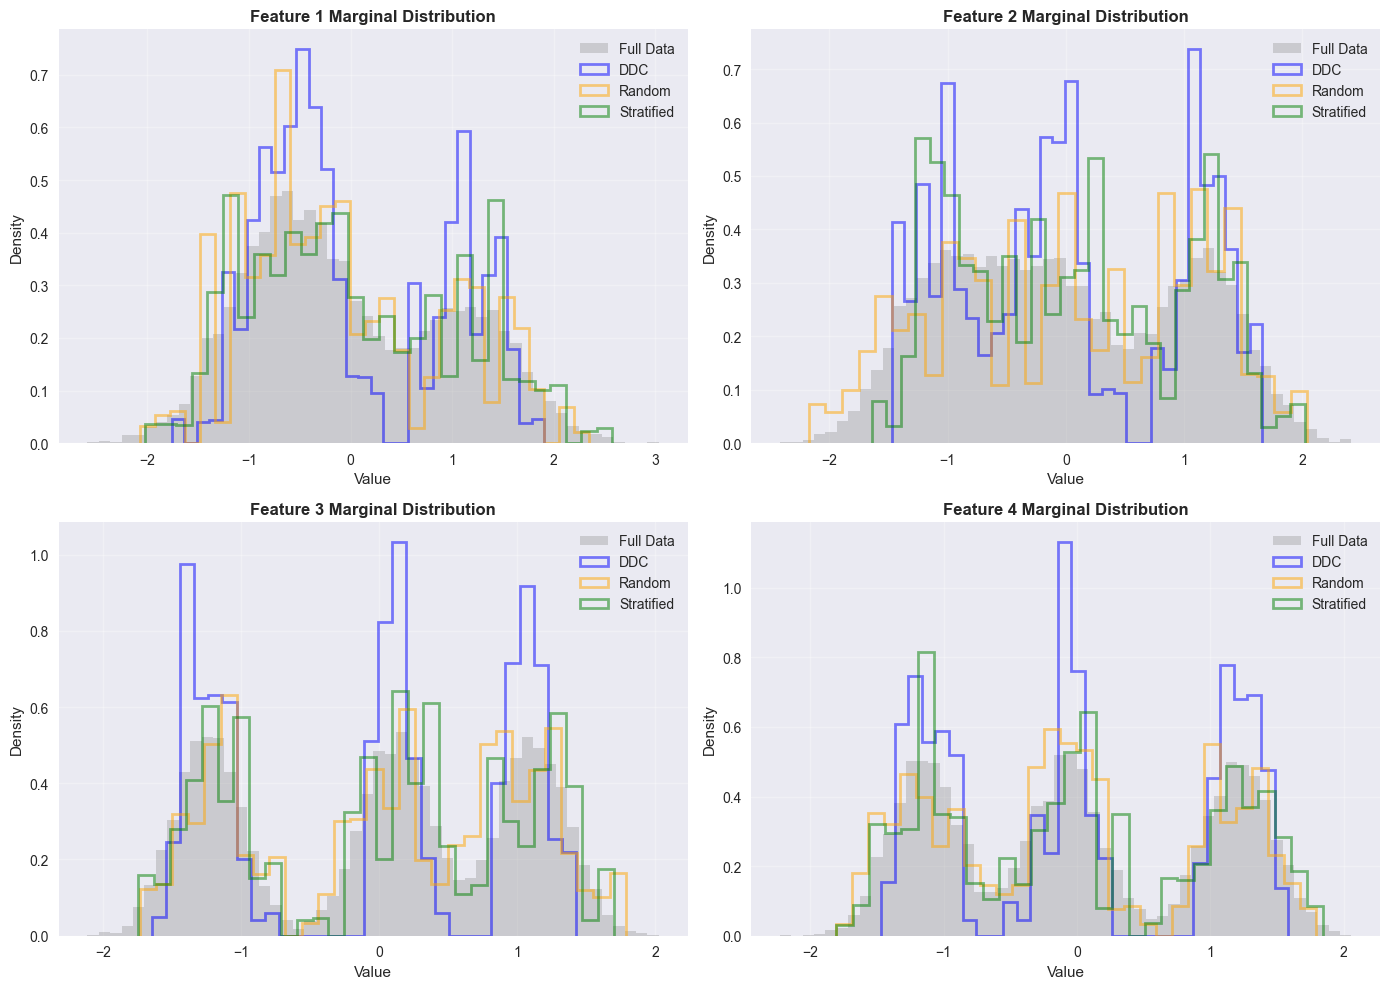

In [9]:
# Plot marginal distributions for first 4 features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for dim in range(4):
    ax = axes[dim]
    
    # Full data histogram
    ax.hist(X[:, dim], bins=50, alpha=0.3, color='gray', label='Full Data', density=True)
    
    # Weighted histograms for coresets
    for S, w, label, color in [
        (S_ddc, w_ddc, 'DDC', 'blue'),
        (S_random, w_random, 'Random', 'orange'),
        (S_strat, w_strat, 'Stratified', 'green')
    ]:
        # Sample from weighted distribution
        n_samples = 5000
        probs = w / w.sum()
        idx = np.random.choice(len(S), size=n_samples, p=probs, replace=True)
        ax.hist(S[idx, dim], bins=30, alpha=0.5, label=label, 
                color=color, density=True, histtype='step', linewidth=2)
    
    ax.set_title(f'Feature {dim+1} Marginal Distribution', fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
# Save figure
import os
os.makedirs('images/tutorials/basic_tabular', exist_ok=True)
plt.savefig('images/tutorials/basic_tabular/spatial_coverage_comparison.png', dpi=150, bbox_inches='tight')

plt.show()

![2D projection comparing spatial coverage of DDC, Random, and Stratified coresets](../_images/spatial_coverage_comparison.png)

*Spatial coverage comparison: DDC (left), Random (center), and Stratified (right) coresets. Point sizes are proportional to weights. DDC ensures all clusters are represented, even small ones.*


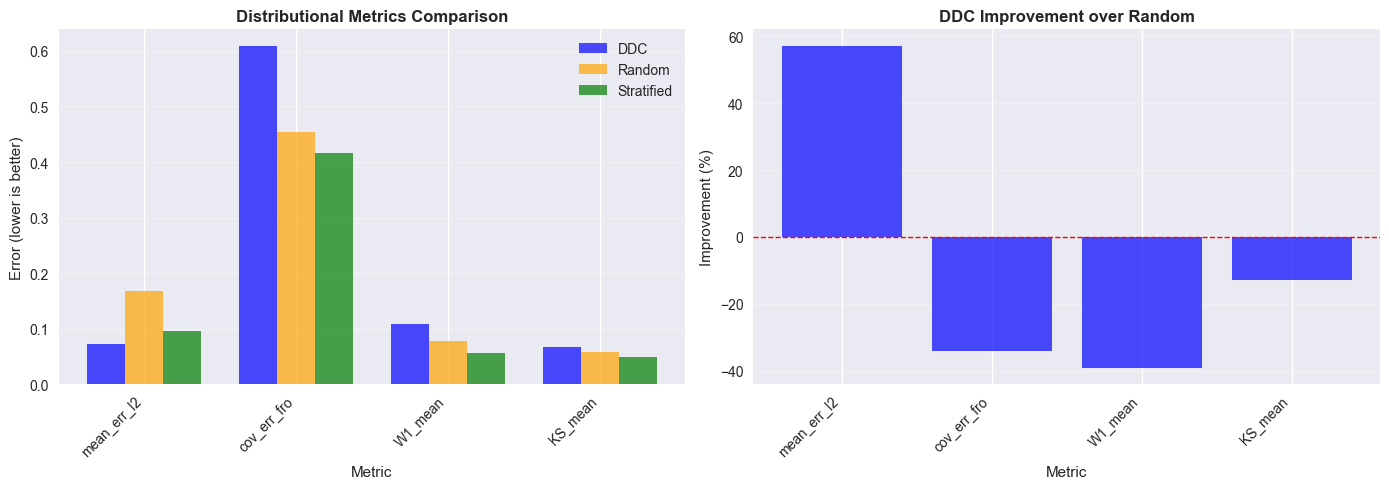

In [10]:
# Bar chart comparing metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics_to_plot = ['mean_err_l2', 'cov_err_fro', 'W1_mean', 'KS_mean']
methods = ['DDC', 'Random', 'Stratified']
colors = ['blue', 'orange', 'green']

x = np.arange(len(metrics_to_plot))
width = 0.25

for i, method in enumerate(methods):
    metrics = [results_df.loc[method, m] for m in metrics_to_plot]
    axes[0].bar(x + i*width, metrics, width, label=method, color=colors[i], alpha=0.7)

axes[0].set_xlabel('Metric')
axes[0].set_ylabel('Error (lower is better)')
axes[0].set_title('Distributional Metrics Comparison', fontweight='bold')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Improvement percentages
improvements = []
for metric in metrics_to_plot:
    random_val = results_df.loc['Random', metric]
    ddc_val = results_df.loc['DDC', metric]
    improvement = (1 - ddc_val / random_val) * 100
    improvements.append(improvement)

axes[1].bar(range(len(metrics_to_plot)), improvements, color='blue', alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Metric')
axes[1].set_ylabel('Improvement (%)')
axes[1].set_title('DDC Improvement over Random', fontweight='bold')
axes[1].set_xticks(range(len(metrics_to_plot)))
axes[1].set_xticklabels(metrics_to_plot, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
# Save figure
import os
os.makedirs('images/tutorials/basic_tabular', exist_ok=True)
plt.savefig('images/tutorials/basic_tabular/metrics_comparison.png', dpi=150, bbox_inches='tight')

plt.show()

## 7. Key Takeaways

### When DDC is Better

- **Clustered data**: DDC preserves cluster structure better than Random
- **Spatial coverage**: DDC ensures all clusters are represented
- **Distributional fidelity**: DDC better preserves marginal distributions

### When Random Might Be Better

- **Very large datasets** (n >> k) with complex non-Gaussian structure
- **Preserving exact global covariance** is critical
- **High-dimensional sparse data**

### Next Steps

- Try `multimodal_clusters.ipynb` for more complex cluster structures
- Try `adaptive_distances.ipynb` for advanced features (presets, adaptive distances)
- See `docs/DDC_ADVANTAGE_CASES.md` for comprehensive analysis

![Histogram comparison of marginal distributions for DDC, Random, and Stratified coresets](../_images/marginal_distributions.png)

*Marginal distribution comparison for the first 4 features. Gray histogram shows full data; colored lines show weighted coreset distributions. DDC better preserves the shape of marginal distributions.*


![Bar charts comparing distributional metrics across methods](../_images/metrics_comparison.png)

*Distributional metrics comparison (left) and DDC improvement over Random (right). DDC excels at mean preservation but may trade off some covariance accuracy for better cluster coverage.*
